# DIVERGING-WAVE ECHOCARDIOGRAPHY - simulations, beamforming, compounding

In this tutorial, it is shown how to simulate an ultrasound image of the heart (a five-chamber view) from the transmit of diverging waves.

The heart will be insonified with seven diverging waves 60-degrees wide.

1.    Scatterers will be provided by the function GENSCAT.
1.    RF signals will be simulated with the function SIMUS.
1.    The RF signals will be I/Q demodulated with RF2IQ,
1.    then beamformed with DAS.
1.    A compound echocardiographic image will eventually be generated.

In [1]:
import pymust, tqdm, pymust.utils
import numpy as np, matplotlib.pyplot as plt

## Select a transducer with GETPARAM

We want a 2.7-MHz 64-element cardiac phased array.

In [2]:
param = pymust.getparam('P4-2v');

The structure param contains the tranducer properties.

## Add transmit apodization

In [3]:
param.TXapodization = np.cos(np.linspace(-1,1,64)*np.pi/2);

## Set the transmit delays with TXDELAY

The left ventricle will be insonified with seven diverging waves 60 degrees wide and tilted at -20 to +20 degrees.

In [5]:
tilt = np.deg2rad(np.linspace(-20,20,7)); # tilt angles in rad
txdel = [None] * 7 # this array will contain the transmit delays

Use TXDELAY to calculate the transmit delays for the 7 diverging waves.

In [6]:
for i, t in enumerate(tilt):
    txdel[i] = pymust.txdelay(param, t, np.deg2rad(60))

These are the transmit delays to obtain a 60 degrees wide circular waves steered at -20 degrees

Text(0.5, 1.0, 'TX delays for a 6$\\circ$-wide -20$\\circ$-tilted wave')

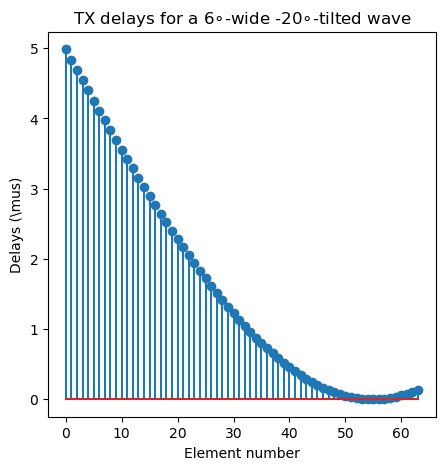

In [7]:
plt.figure(figsize = (5,5))
plt.stem(txdel[0][0]*1e6)
plt.xlabel('Element number')
plt.ylabel('Delays (\mus)')
plt.title('TX delays for a 6$\circ$-wide -20$\circ$-tilted wave')


## Simulate an acoustic pressure field with PFIELD

Check what the sound pressure fields look like.

Define a 100 $\times$ 100 polar grid using IMPOLGRID:

In [8]:
xi,zi = pymust.impolgrid(np.array([100, 100]),15e-2,np.deg2rad(120),param);

Simulate an RMS pressure field...

In [9]:
P, _, _= pymust.pfield(xi,0*xi,zi,txdel[0],param)

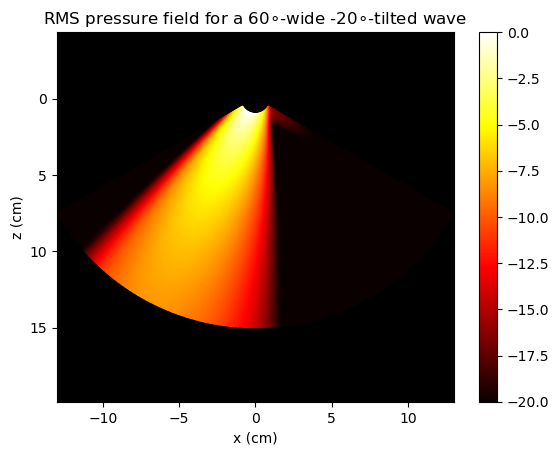

In [10]:
pymust.utils.polarplot(xi*1e2,zi*1e2,20*np.log10(P/np.max(P)), cmap = 'hot')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.title('RMS pressure field for a 60${\circ}$-wide -20${\circ}$-tilted wave')

plt.colorbar()
plt.clim(-20, 0) #dynamic range = [-20,0] dB


## Simulate RF signals with SIMUS

We will now simulate seven series of RF signals. Each series will contain 64 RF signals, as the simulated phased array contains 64 elements. We first create scatterers with GENSCAT from a clipart image of the ventricle stored in heart.jpg.

x, y, and z contain the scatterers' positions. RC contains the reflection coefficients.

In [11]:
import matplotlib.image as mpimg
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [12]:
I = rgb2gray(mpimg.imread('data/heart.jpg')) 
#% Pseudorandom distribution of scatterers (depth is 15 cm)
x,y,z,RC = pymust.genscat(np.array([np.nan, 15e-2]),1540/param.fc,I);

Take a look at the scatterers. The backscatter coefficients are gamma-compressed to increase the contrast.

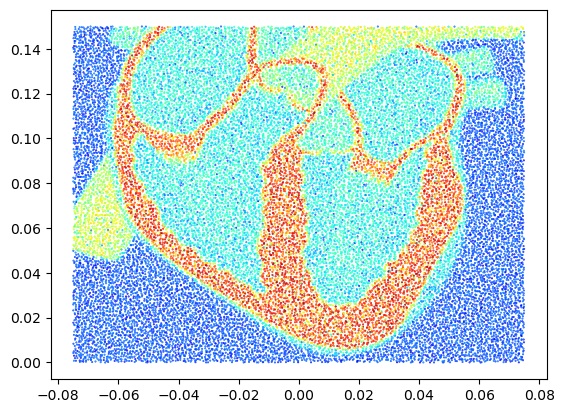

In [13]:
plt.scatter(x, z,  s = .2, c = np.abs(RC) **0.25, cmap ='jet')

Simulate the seven series of RF signals with SIMUS. The RF signals will be sampled at 4 $\times$ center frequency.

In [14]:
RF =[0] * len(txdel) # this array will contain the RF series
param.fs = 4*param.fc; # sampling frequency in Hz

for k, t in tqdm.tqdm(enumerate(tilt)):
    RF[k], _ = pymust.simus(x,y,z,RC,txdel[k],param)


7it [01:53, 16.21s/it]


This is the 32th RF signal of the 1st series:

Text(0.5, 1.0, 'RF signal of the 32$^{th}$ element (1$^{st}$ series, tilt = -20${\\circ}$)')

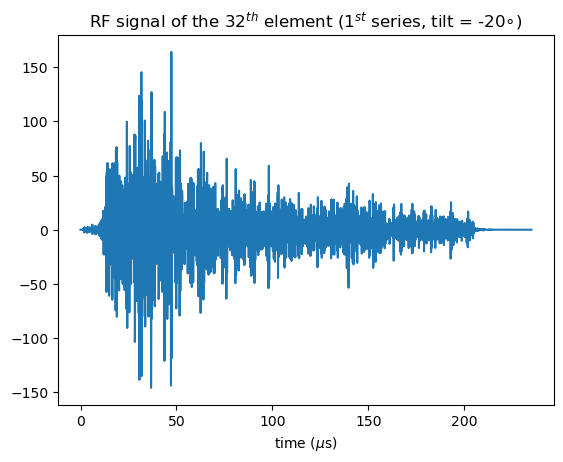

In [22]:
rf = RF[0][:,31]
t = np.arange(len(rf))/param.fs*1e6; #% time (ms)
plt.plot(t,rf)
plt.xlabel('time ($\mu$s)')
plt.title('RF signal of the 32$^{th}$ element (1$^{st}$ series, tilt = -20${\circ}$)')

Text(0.5, 1.0, 'RF signal of the 32$^{th}$ element (1$^{st}$ series, tilt = -20${\\circ}$)')

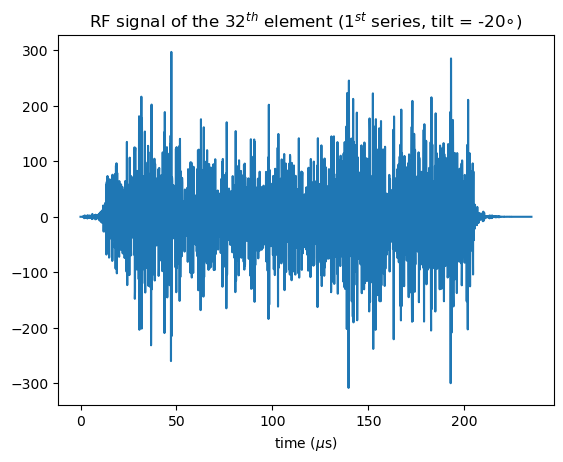

In [23]:
RF_tgc, _ = pymust.tgc(RF[0])
plt.plot(t,RF_tgc[:,31])
plt.xlabel('time ($\mu$s)')
plt.title('RF signal of the 32$^{th}$ element (1$^{st}$ series, tilt = -20${\circ}$)')

## Demodulate the RF signals with RF2IQ

Before beamforming, the RF signals must be I/Q demodulated.

Text(0.5, 1.0, 'RF signal of the 32$^{th}$ element (1$^{st}$ series, tilt = -20${\\circ}$)')

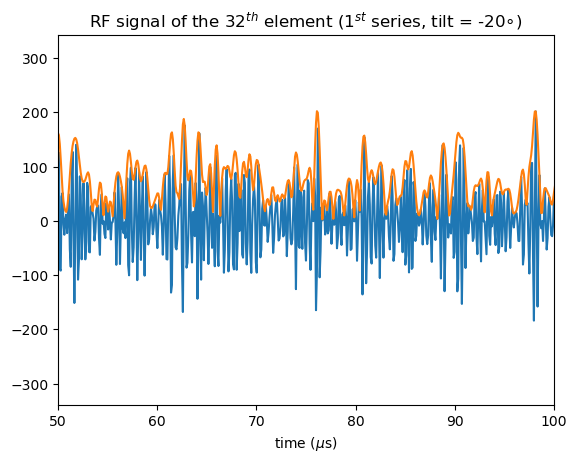

In [24]:
IQ_tgc = pymust.rf2iq(RF_tgc,param.fs,param.fc)

plt.plot(t,RF_tgc[:,31])
plt.plot(t,np.abs(IQ_tgc[:,31]))
plt.xlim(50, 100)

plt.xlabel('time ($\mu$s)')
plt.title('RF signal of the 32$^{th}$ element (1$^{st}$ series, tilt = -20${\circ}$)')

In [25]:
IQ = [None] * len(tilt)
for k, _ in enumerate(tilt):
    IQ[k] = pymust.rf2iq(RF[k],param.fs,param.fc)

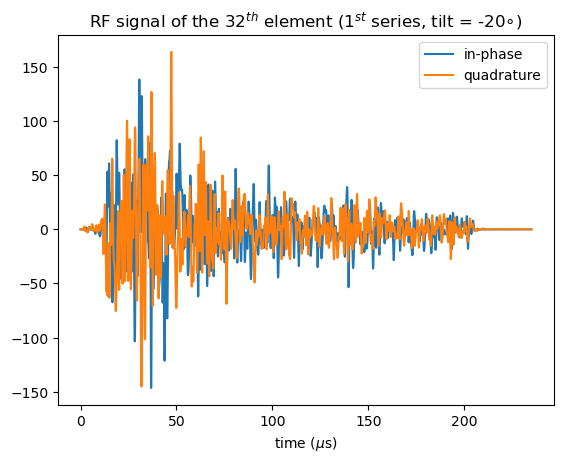

In [26]:
iq = IQ[0][:,31]
t = np.arange(len(rf))/param.fs*1e6; #% time (ms)
plt.plot(t,np.real(iq), label = 'in-phase')
plt.plot(t,np.imag(iq), label = 'quadrature')

plt.xlabel('time ($\mu$s)')
plt.title('RF signal of the 32$^{th}$ element (1$^{st}$ series, tilt = -20${\circ}$)')
plt.legend()

## Beamform the I/Q signals with DAS

To generate images of the left ventricle, beamform the I/Q signals onto a 256 $\times$ 128 polar grid.

Generate the image (polar) grid using IMPOLGRID.

In [27]:
xi,zi = pymust.impolgrid(np.array([256, 128]),15e-2,np.deg2rad(80), param)

Beamform the I/Q signals using a delay-and-sum with the function DAS.

In [28]:

bIQ = np.zeros((256,128,7), dtype = np.complex64)  # this array will contain the 7 I/Q images
for k, _ in enumerate(txdel):
    param.TXdelay = txdel[k]
    M = pymust.dasmtx(IQ[k], xi,zi,txdel[k],param);
    bIQ[:,:,k] = pymust.utils.applyDasMTX(M, IQ[k], xi.shape)

(32768, 1) (32768, 64)
(32768, 1) (32768, 64)
(32768, 1) (32768, 64)
(32768, 1) (32768, 64)
(32768, 1) (32768, 64)
(32768, 1) (32768, 64)
(32768, 1) (32768, 64)


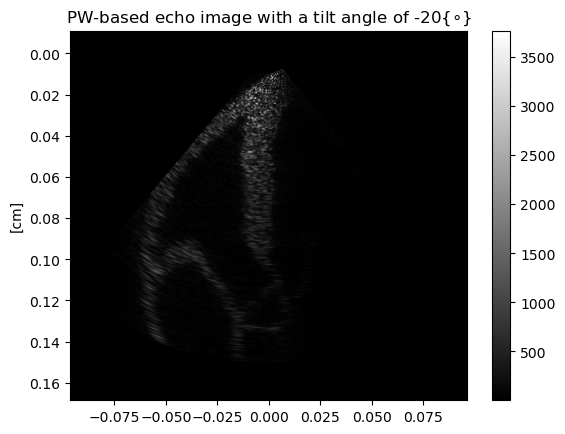

In [29]:
I = np.abs(bIQ[:,:,0])
pymust.utils.polarplot(xi, zi, I, cmap = 'gray')
plt.title('PW-based echo image with a tilt angle of -20{$\circ$}')
plt.axis('equal')
plt.ylabel('[cm]')
plt.colorbar()


## Time-gain compensate the beamformed I/Q with TGC

Time-gain compensation tends to equalize the amplitudes along fast-time.

In [30]:
for k in range(7):
    bIQ[:,:,k], _ = pymust.tgc(bIQ[:,:,k])

## Check the ultrasound images

An ultrasound image is obtained by log-compressing the amplitude of the beamformed I/Q signals. Have a look at the images obtained when steering at -20 degrees.

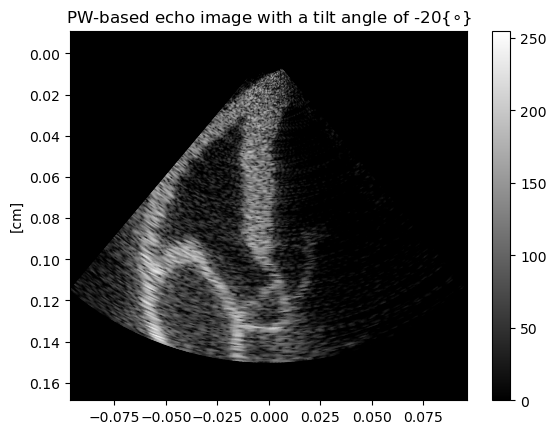

In [31]:
I = pymust.bmode(bIQ[:,:,0],40) # log-compressed image
pymust.utils.polarplot(xi, zi, I, cmap = 'gray')
plt.title('PW-based echo image with a tilt angle of -20{$\circ$}')
plt.axis('equal')
plt.ylabel('[cm]')
plt.colorbar()


The individual images are of poor quality. The compound image obtained with a series of 7 diverging waves steered at different angles is of better quality:

Text(0.5, 1.0, 'Compound PW-based cardiac echo image')

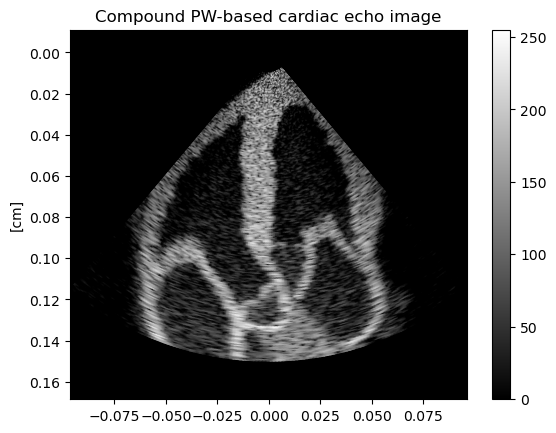

In [32]:
cIQ = np.sum(bIQ,2) # this is the compound beamformed I/Q
I = pymust.bmode(cIQ,40); #log-compressed image
pymust.utils.polarplot(xi, zi, I, cmap = 'gray')
plt.colorbar()
#plt.clim(-40,0)
plt.axis('equal')
plt.ylabel('[cm]')
plt.title('Compound PW-based cardiac echo image')